<center><h1>Projet Image - Transfert de couleur par transport optimal</h1></center>

Codé par Laurie Dussère, Elisa Duz, Alexandre Gendreau, Nicolas Julia (5MA)

# 1. Chargement des libraires

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage as sd

from time import time

from PIL import Image
import cv2 as cv
import requests
from io import BytesIO

## 2. Codage de la fonction `Sinkhorn`
La fonction `Sinkhorn` code le transport optimal, tel que présenté dans le rapport ci-joint. Il est possible de montrer que le problème se réécrit comme:
$$P^*_{varepsilon} = \mathrm{diag}(u^\star)K^{\epsilon}\mathrm{diag}(v^\star)$$
La solution est obtenu en projetant alternativement sur le domaine des contraintes. 

On initialise le problème, en posant $$P_0 =  K^\epsilon = \exp\left(-\frac{1}{\epsilon C}\right)$$
où $C$ définit la matrice de coût de taille $n \times m$, où $n$ désigne le nombre de pixels de l'image source, et $m$ celui de l'image target. On calcule itérativement les valeurs de la suite des $(u_k)_k$, et $(v_k)_k$ pour converger vers $u^\star$ et $v^\star$ respectivement:
$$u_{k+1} \leftarrow \frac {a} {Kv_k} \;\;\;  v_{k+1} \leftarrow \frac {b} {K^Tu_k}$$ 
Les vecteurs $a$ et $b$ donc initialisés aléatoirement et sont normalisés. On a choisit de prendre $$a_i = \frac{1}{n}, \forall i , b_j = \frac{1}{m}, \forall j$$

Cet algorithme est à la fois applicable sur des vecteurs en 1D, ou alors des images en 3D, une fois applatie.

In [2]:
def sinkhorn(a,b,C,epsilon,niter):
    # a is the first histogram
    # b is the second histogram
    # C is the cost matrix
    # epsilon is the regularization parameter
    # niter is the maximum number of Sinkhorn iterations
    n = len(a)
    m = len(b)

    iter = 0
    
    #Initiliaze vectors u, v and matrix K
    u = 1/n*np.ones(n)
    v = 1/m*np.ones(m)
    K = np.exp(-1/epsilon*C)
    
    # Sinkhorn loop to update u and v
    while iter <= niter:
      u_prec = u
      v_prec = v
      u = a/K.dot(v)
      v = b/np.transpose(K).dot(u_prec)
      iter += 1

    P = np.diag(u).dot(K.dot(np.diag(v)))
    return P

# 2. Application au transfert de couleur
Une application de cet algorithme désigne le transfert de couleur d'une image source, vers une image target. Considérons les images suivantes:

In [3]:
def chargeData(name):
    if name == 'venise':
        url = 'https://plmlab.math.cnrs.fr/dossal/projetsimages2022-2023/-/tree/main/Data/venise.jpg'        
        response = requests.get(url)
        res = np.array(Image.open(BytesIO(response.content))).astype(float)
    if name == 'renoir':
        url = 'https://plmlab.math.cnrs.fr/dossal/projetsimages2022-2023/-/tree/main/Data/renoir.jpg'
        response = requests.get(url)
        res = np.array(Image.open(BytesIO(response.content))).astype(float)
    return res

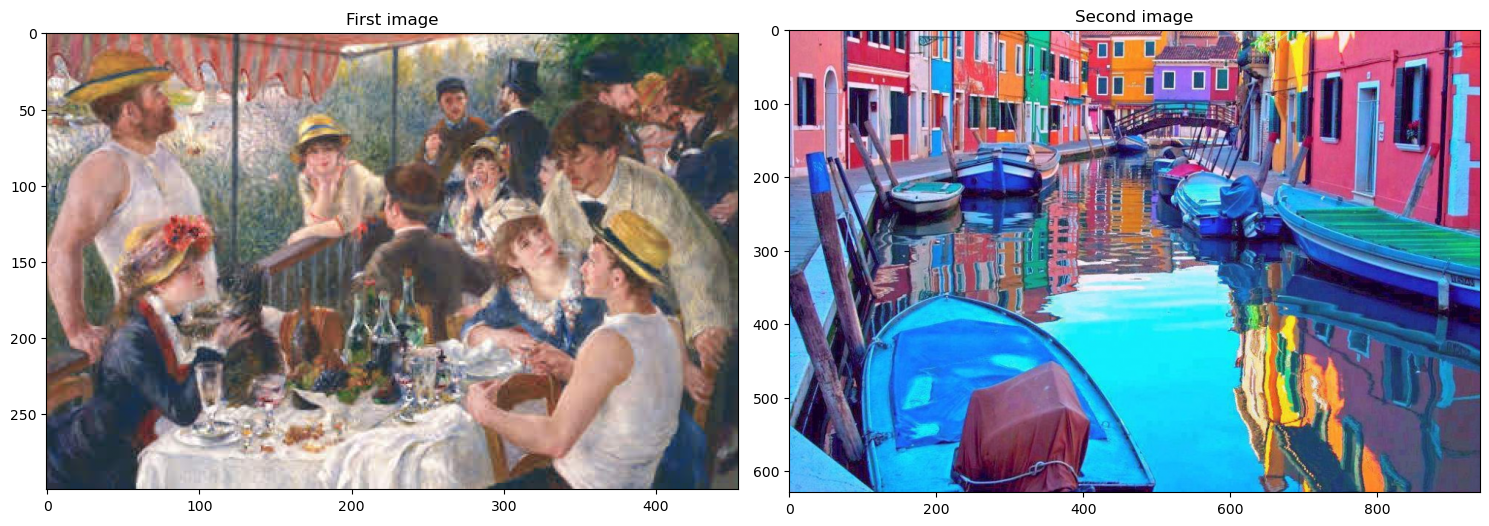

In [6]:
im1 = cv.cvtColor(cv.imread('renoir.jpg'),cv.COLOR_BGR2RGB)/255
im2 = cv.cvtColor(cv.imread('venise.jpg'),cv.COLOR_BGR2RGB)/255

#we display the images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axes[0].imshow(im1)
axes[0].set_title('First image')
axes[1].imshow(im2)
axes[1].set_title('Second image')
fig.tight_layout()

On représente les images en tant que pixels dans un espace en 3D. Cette représentation montre la distribution des pixels dans un espace en 3D. 

In [8]:
u = im1
v = im2
s = 1                            
if s == 1:
        usubsample = u
        vsubsample = v
else:
  usubsample = u[1::s,1::s,0:3]
  vsubsample = v[1::s,1::s,0:3]
X = usubsample.reshape((usubsample.shape[0]*usubsample.shape[1],3))
Y = vsubsample.reshape((vsubsample.shape[0]*vsubsample.shape[1],3))

In [9]:
# a function to plot pixels in the RGB color space

def plot_pixel_3D(im,fig0,i,ni,nj):
    Z=im.reshape([im.shape[0]*im.shape[1],3])
    nb = 3000
    r = np.random.RandomState(42)
    idZ = r.randint(Z.shape[0], size=(nb,))
    Zs = Z[idZ, :]
    axis = fig0.add_subplot(ni, nj, i, projection="3d")
    axis.scatter(Zs[:, 0], Zs[:,1],Zs[:, 2], c=Zs,s=100)
    axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue")

(Text(0.5, 0, 'Red'), Text(0.5, 0.5, 'Green'), Text(0.5, 0, 'Blue'))

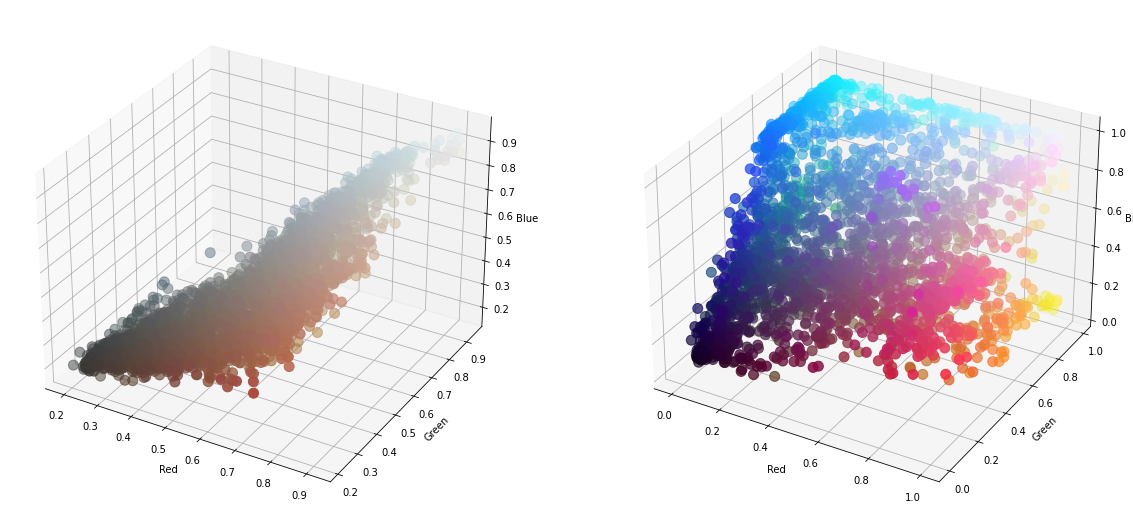

In [10]:
nb   = 3000
r    = np.random.RandomState(42)
idX  = r.randint(X.shape[0], size=(nb,))
idY  = r.randint(Y.shape[0], size=(nb,))
Xs   = X[idX, :]
Ys   = Y[idY, :]

fig  = plt.figure(2, figsize=(20, 10))
axis = fig.add_subplot(1, 2, 1, projection="3d")
axis.scatter(Xs[:, 0], Xs[:,1],Xs[:, 2], c=Xs,s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue")
axis = fig.add_subplot(1, 2, 2, projection="3d")
axis.scatter(Ys[:, 0], Ys[:,1],Ys[:, 2], c=Ys,s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue")

A terme, on va chercher à modifier la distribution de gauche (qui est l'image source), pour la faire fitter avec la distribution de droite (image target).

### 2.1. Application sur des images de petites dimensions
#### 2.1.1. Application de l'algorithme de Sinkhorn
Dans un premier temps, on va appliquer l'algorithme de Sinkhorn à des images de petites dimensions. En effet, on verra que cet algorithme n'est pas adapté pour des images en trop grandes dimensions. Le calcul de la matrice $C$ est proportionnel à la taille des deux images. Ainsi, plus les deux images sont grandes, plus la calcul de $C$ est long. Dans le cas d'une image de même taille $256\times 256$, on se retrouve alors avec $4.29\times 10^9$ éléments à calculer pour la matrice $C$, ce qui est exponentiellement long. 

C'est pour cela que l'on réduit la taille des images, en regroupant les pixels par blocs de pixels. 

Text(0.5, 1.0, '$\\beta$')

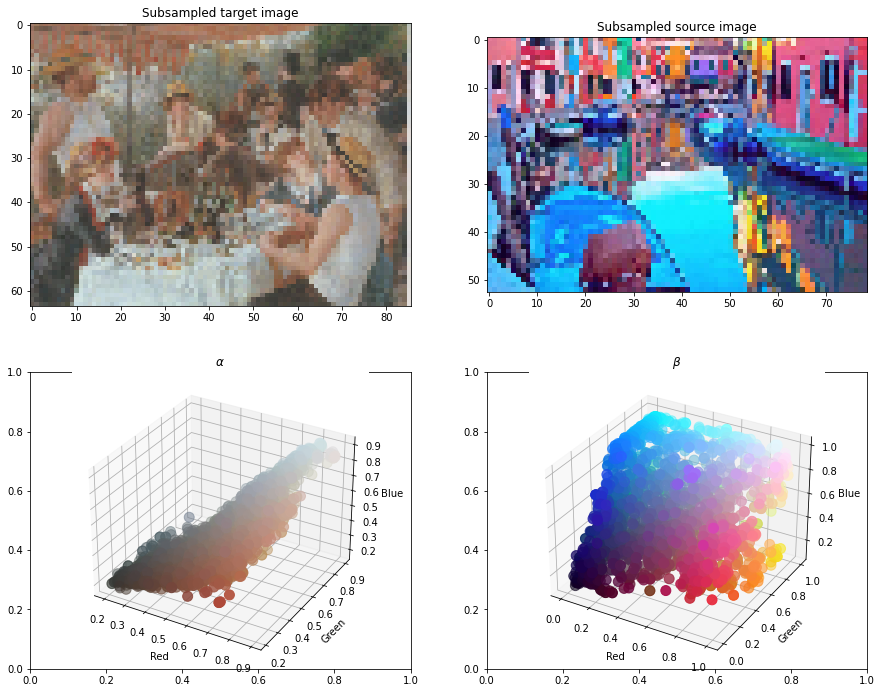

In [13]:
s = 12
im1_subsample = im1[1::s,1::s,0:3]
im2_subsample = im2[1::s,1::s,0:3]

fig, axes = plt.subplots(2,2, figsize=(15, 12))

axes[0][0].imshow(im1_subsample)
axes[0][1].imshow(im2_subsample)

axes[0][0].set_title('Subsampled target image')
axes[0][1].set_title('Subsampled source image')


plot_pixel_3D(im1_subsample,fig,3,2,2)
plot_pixel_3D(im2_subsample,fig,4,2,2)

axes[1][0].set_title(r'$\alpha$')
axes[1][1].set_title(r'$\beta$')


Essentiellement, la distribution reste identique, même si le nombre de pixel est réduit. 

Dnas notre cas, on va consider la distance RGB, et calculer la matrice $C$ telle que chaque élément vaut:
$$C_{i,j} = \|X_i - Y_j\|$$
où $X$ définit l'image source et $Y$ définit l'image target.

On va calculer la matrice $P$ de transport à l'aide de l'algorithme de Sinkhorn.

On note $\tilde{X}$ l'image modifiée. On associe à chaque voxel (ensemble de 3 pixels) de $X$, le voxel le plus probable de $Y$ en prenant:
$$\tilde{X}_i = Y_k$$
avec  $k=\arg\max_j P^*_{i,j}$.
On reshape l'image $\tilde{X}$ modifiée, pour re-obtenir la taille de l'image originale. 

In [14]:
# 3D color position of pixels of both images
X = im1_subsample.reshape((-1,3))
Y = im2_subsample.reshape((-1,3))
n = X.shape[0]
m = Y.shape[0]
a,b = 1/n*np.ones(n), 1/m*np.ones(m)

23045248

In [15]:
C = np.reshape(np.array([[np.linalg.norm(u-v,2)**2 for u in X for v in Y]]),(n,m))

In [16]:
eps = 0.01
niter = 15
pi = sinkhorn(a,b,C,eps,niter)
k_opt = [[np.argmax(pi[i,:])] for i in range(n)]
X_tilde = Y[k_opt,:]
im1_colortransfer = X_tilde.reshape((im1_subsample.shape))

Text(0.5, 1.0, '$\\beta$')

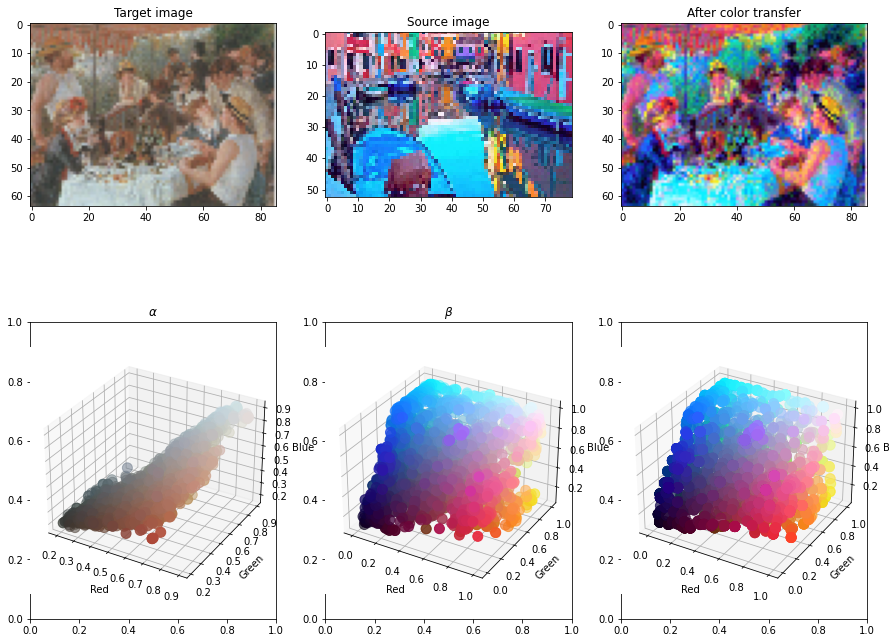

In [17]:
#Plot the result

fig, axes = plt.subplots(2,3, figsize=(15, 12))

axes[0][0].imshow(im1_subsample)
axes[0][1].imshow(im2_subsample)
axes[0][2].imshow(im1_colortransfer)
axes[0][0].set_title('Target image')
axes[0][1].set_title('Source image')
axes[0][2].set_title('After color transfer')

plot_pixel_3D(im1_subsample,fig,4,2,3)
plot_pixel_3D(im2_subsample,fig,5,2,3)
plot_pixel_3D(im1_colortransfer,fig,6,2,3)

axes[1][0].set_title(r'$\alpha$')
axes[1][1].set_title(r'$\beta$')


#### 2.1.2. Application d'un filtre bilatéral afin de lisser l'image
On doit appliquer un filtre bilatéral sur la différence entre l'image d'entrée et l'image de sortie. 

In [18]:
def fenetre(image, vois, i_central, j_central):
    n, m, c = image.shape
    fenetre = np.ones((n,m,c)) * image[i_central, j_central, :]
    #On cherche à déterminer les bords de la fenêtre associée au pixel (i,j) de l'image pour la découper correctement
    if (i_central - np.floor(vois/2)) < 0:
        bord_haut = 0
    else : 
        bord_haut = int(i_central - np.floor(vois/2))
    if (i_central + np.floor(vois/2)) > n :
        bord_bas = n
    else : 
        bord_bas = int(i_central + np.floor(vois/2))
    if (j_central - np.floor(vois/2)) < 0 : 
        bord_gauche = 0
    else : 
        bord_gauche = int(j_central - np.floor(vois/2))
    if (j_central + np.floor(vois/2)) > m :
        bord_droite = m
    else : 
        bord_droite = int(j_central + np.floor(vois/2))

    fenetre[bord_haut:bord_bas, bord_gauche:bord_droite, :] = image[bord_haut:bord_bas, bord_gauche:bord_droite, :]
    return fenetre

In [19]:
def distance_RGB(x,y):
  return np.sqrt((x[0]-y[0])**2+(x[1]-y[1])**2+(x[2]-y[2])**2)
  
def distance_vois(fen,central_i,central_j):
  list_distance = []
  pixel_central = fen[central_i, central_j,:]
  n,m,c = fen.shape
  for u in range(n):
    for v in range(m):
      #if u != central_i or v != central_j : 
      list_distance.append(distance_RGB(pixel_central,fen[u,v,:]))
  return np.array(list_distance)

In [20]:
def poids(list_distance, sigma):
  poids = np.exp(list_distance*sigma)
  poids[poids == 1] = 0
  return poids

def guided_filter_pixels(fen, central_i,central_j, sigma):
    n,m,c = np.shape(fen)
    dist = distance_vois(fen, central_i,central_j)
    moy = np.zeros(3)
    fen_channel = np.zeros((n,m))
    for channel in range(c):
      fen_channel = fen[:,:,channel]
      w = poids(dist, sigma)
      moy[channel] = np.average(fen_channel.reshape((-1)), weights=w/np.sum(w))
    return np.clip(moy,0,255)

In [21]:
def guided_filter(image, sigma,vois):
    n,m,c = image.shape
    res = np.zeros(image.shape)

    for i in range(n):
        for j in range(m):
            central_i = i
            central_j = j
            fen = fenetre(im1_colortransfer, vois, central_i,central_j)
            moy = guided_filter_pixels(fen, central_i, central_j, sigma)
            res[i,j,:] = moy
    return res

In [22]:
diff = im1_colortransfer -  im1_subsample
smooth_im = guided_filter(diff, 0.01, 7)
im = (im1_colortransfer + smooth_im)/2

Text(0.5, 1.0, '$\\beta$')

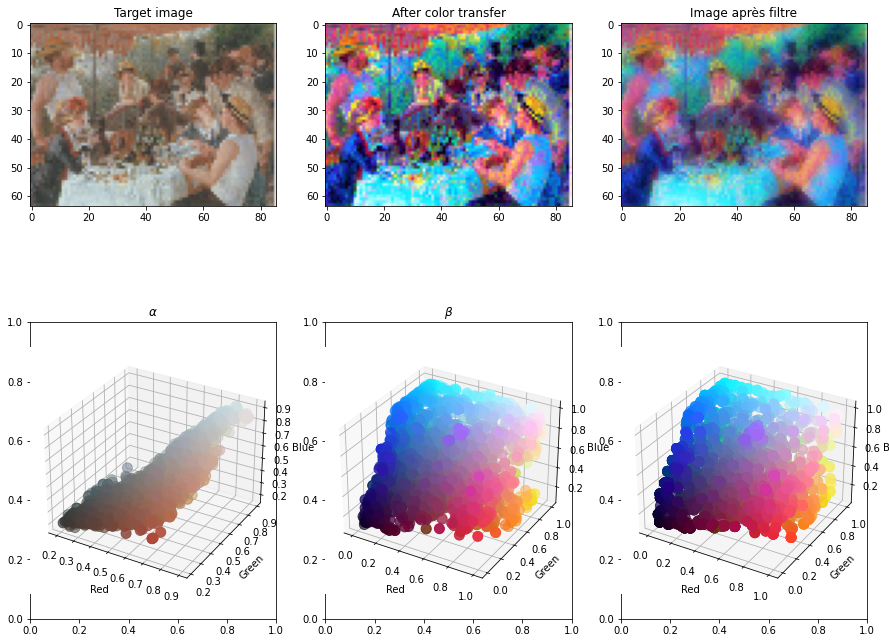

In [24]:
fig, axes = plt.subplots(2,3, figsize=(15, 12))

axes[0][0].imshow(im1_subsample)
axes[0][1].imshow(im1_colortransfer)
axes[0][2].imshow(im)
axes[0][0].set_title('Target image')
axes[0][1].set_title('After color transfer')
axes[0][2].set_title('Image après filtre')


plot_pixel_3D(im1_subsample,fig,4,2,3)
plot_pixel_3D(im2_subsample,fig,5,2,3)
plot_pixel_3D(im1_colortransfer,fig,6,2,3)

axes[1][0].set_title(r'$\alpha$')
axes[1][1].set_title(r'$\beta$')

### 2.2. Application sur des images de grandes dimensions
Cet algorithme a été implémenté par Julie Delon. Il contient des codes qui sont adaptés pour des images en grandes dimensions. Au lieu de réduire la taille de l'image, on applique des convolutions. 

#### 2.2.1. Application de l'algorithme de Sinkhorn

In [25]:
# 3D sinkhorn with convolutions
t1 = time()
niter = 20
N = 64        # histogram on a N x N x N uniform grid  
eps = 0.01    # regularisation parameter for Sinkhorn

# probability vectors
u          = np.floor(np.double(im1*(N-0.01)))     # first image with N values for each channel 
v          = np.floor(np.double(im2*(N-0.01)))     # second image with N values for each channel

# we compute histograms for both images
f, g = np.zeros((N,N,N)), np.zeros((N,N,N))          # initialization 
for k in range(u.shape[0]):
    for j in range(u.shape[1]):
        f[int(u[k,j,:][0]),int(u[k,j,:][1]),int(u[k,j,:][2])]+=1
for k in range(v.shape[0]):
    for j in range(v.shape[1]):
        g[int(v[k,j,:][0]),int(v[k,j,:][1]),int(v[k,j,:][2])]+=1
                
f, g = f/np.sum(f), g/np.sum(g)       


# initialization of vectors a and b for Sinkhorn 
a, b = np.ones((N,N,N)), np.ones((N,N,N))
a, b = a/np.sum(a), b/np.sum(b)       


# distance matrix and corresponding filter for convolutions (= replaces matrix vectors products)
h=np.zeros((2*N-1,))
x = np.linspace(0,N-1,N)
w = np.exp(-x**2/(N**2*eps)) 
h[N-1:2*N-1]=np.copy(w)
h[0:N-1]= w[N:0:-1]

# Sinkhorn 
for t in range(niter):
    Ab = sd.convolve(b,h.reshape(1,1,2*N-1),mode='constant')   
    Ab = sd.convolve(Ab,h.reshape(1,2*N-1,1),mode='constant') 
    Ab = sd.convolve(Ab,h.reshape(2*N-1,1,1),mode='constant')  
    a = f / Ab
    Aa = sd.convolve(a,h.reshape(1,1,2*N-1),mode='constant')
    Aa = sd.convolve(Aa,h.reshape(1,2*N-1,1),mode='constant')  
    Aa = sd.convolve(Aa,h.reshape(2*N-1,1,1),mode='constant') 
    b = g / Aa

t2 = time()
print(t2-t1) 
print('sinkhorn done')

7.146412134170532
sinkhorn done


21.175302267074585


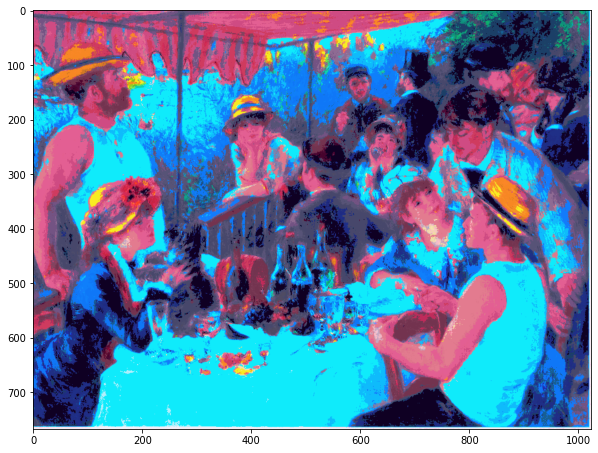

In [26]:
# do the computations only for g != 0

t1 = time()

otmap = np.zeros((N,N,N,3))

X = np.array(np.nonzero(f))
Y = np.array(np.nonzero(g))
bY = b[tuple(Y)]

for t in range(X.shape[1]):
    l,m,n = np.uint8(X[:,t])
    temp = np.exp(-((Y[0]-l)**2+(Y[1]-m)**2+(Y[2]-n)**2)/(N**2*eps))*bY
    ind = np.argmax(temp, axis=None)
    otmap[l,m,n,:] = Y[:,ind]
    
out = otmap[np.uint8(u[:,:,0]),np.uint8(u[:,:,1]),np.uint8(u[:,:,2]),:]/N

t2 = time()
print(t2-t1)

plt.figure(figsize = (10,10))
plt.imshow(out)

#### 2.2.2. Application d'un algorithme de filtre guidé
On applique un filtre guidé à l'image afin de lisser l'image.

In [27]:
def average_filter(u,r):    # implementation with integral images
    # uniform filter with a square (2*r+1)x(2*r+1) window 
    # u is a 2d image
    # r is the radius for the filter
   
    (nrow, ncol)                                      = u.shape
    big_uint                                          = np.zeros((nrow+2*r+1,ncol+2*r+1))
    big_uint[r+1:nrow+r+1,r+1:ncol+r+1]               = u
    big_uint                                          = np.cumsum(np.cumsum(big_uint,0),1)       # integral image
        
    out = big_uint[2*r+1:nrow+2*r+1,2*r+1:ncol+2*r+1] + big_uint[0:nrow,0:ncol] - big_uint[0:nrow,2*r+1:ncol+2*r+1] - big_uint[2*r+1:nrow+2*r+1,0:ncol]
    out = out/(2*r+1)**2
    
    return out

def todo_guided_filter(u,guide,r,eps):
    C           = average_filter(np.ones(u.shape), r)   # to avoid image edges pb 
    mean_u      = average_filter(u, r)/C
    mean_guide  = average_filter(guide, r)/C
    corr_guide  = average_filter(guide*guide, r)/C
    corr_uguide = average_filter(u*guide, r)/C
    var_guide   = corr_guide - mean_guide * mean_guide
    cov_uguide  = corr_uguide - mean_u * mean_guide

    alph = cov_uguide / (var_guide + eps)
    beta = mean_u - alph * mean_guide

    mean_alph = average_filter(alph, r)/C
    mean_beta = average_filter(beta, r)/C

    q = mean_alph * guide + mean_beta
    return q

In [28]:
diff = out -  im1
out2 = np.zeros_like(im1)

for i in range(3):
    out2[:,:,i] = todo_guided_filter(diff[:,:,i], im1[:,:,i], 20,1e-4 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


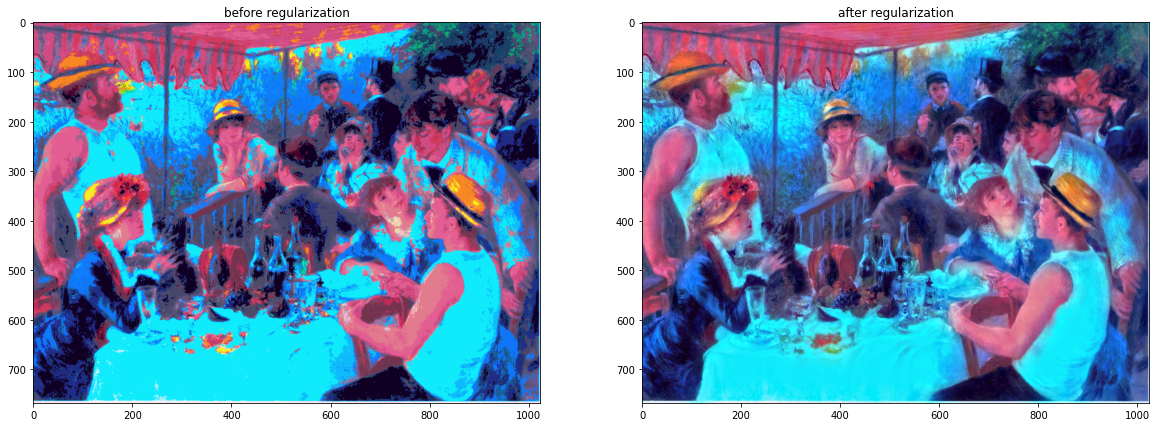

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes[0].imshow(out)
axes[0].set_title('before regularization')
axes[1].set_title('after regularization')
axes[1].imshow(out2+im1)
plt.show()